In [23]:
from IPython.display import clear_output

In [2]:
!pip install timm
!pip install fastai
clear_output()

In [1]:
import timm
from timm import create_model

In [2]:
seed = 999
IMG_SIZE = 224
BATCH_SIZE = 14
NUM_WORKERS = 8

In [3]:
import torch
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [42]:
pwd # 현재 위치

'/workspace'

# Load Train Dataset

In [4]:
#!rm -rf /workspace/dataset/sick/dataset/*.ipynb_checkpoints
!rm -rf `find -type d -name .ipynb_checkpoints`

In [5]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
transforms = torch.nn.Sequential(
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.Resize(IMG_SIZE)
)

img_data = ImageFolder(root="/workspace/dataset/sick/dataset",
                      transform = transforms)


In [6]:
set(img_data.targets), img_data.classes

({0, 1, 2, 3}, ['녹병', '잿빛곰팡이병', '정상', '흰가루병'])

In [7]:
# Look how img_data varaiable are composed
for i in img_data.imgs:
    print(i)
    break

('/workspace/dataset/sick/dataset/녹병/rust100.jpeg', 0)


In [8]:
import pandas as pd
from sklearn.utils import shuffle

df = {
    "path" : [x[0][10:] for x in img_data.imgs],
    "label" : img_data.targets,
}
df = pd.DataFrame(df)
train = shuffle(df)

# Total train dataset 
len(train) 

686

In [9]:
n = len(img_data.classes)

In [10]:
nums =[0]*n
for t in train['label']:
    nums[t]+=1
    
# Numbers of Image about each class
nums

[59, 196, 359, 72]

In [11]:
from fastai.vision.all import *

In [12]:
data = ImageDataLoaders.from_df(train, # train DataFrame
                                valid_pct=0.2, #80-20 train-validation split
                           seed=seed, #seed
                           fn_col='path', 
                           label_col='label',
                           blocks=(ImageBlock, MultiCategoryBlock), #The type of target
                           bs=BATCH_SIZE, 
                           num_workers=NUM_WORKERS, 
                                # Augmentation
                           item_tfms=Resize(IMG_SIZE),
                           batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms

In [13]:
#print(img_data.class_to_idx)
#data.show_batch()

In [14]:
# check available batch size
for i in range(1,1000):
    if (len(data.train) + len(data.valid)) == (len(df)//i):
        print(i)

14


In [15]:
assert (len(data.train) + len(data.valid)) == (len(df)//BATCH_SIZE)

In [16]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

61

# Load Model 

In [17]:
# 여기서 다운로드 진행하면 과정이 안 보이고 답답해서
# 미리 설치하고 복사하면 빨라짐
# 설치 주소는 해당 파일 삭제하면 출력됨
# (wget https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224_22kto1k.pth)

if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '/workspace/swin_base_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_base_patch4_window7_224_22kto1k.pth'

In [18]:
model = create_model('swin_base_patch4_window7_224',  # large는 overfitting, small은 loss는 낮지만 accuracy가 낮음
                     pretrained=True,
                     num_classes=len(img_data.classes))

In [19]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

9

In [20]:
learn = Learner(data,
                model,
                opt_func = QHAdam,
                loss_func= FocalLossFlat(),
               ).to_fp16()

In [21]:
#learn.lr_find(end_lr=1e-1)

# Train

epoch,train_loss,valid_loss,time
0,0.229991,0.112130,02:04
1,0.083753,0.012859,02:02


Better model found at epoch 0 with valid_loss value: 0.11213028430938721.
Better model found at epoch 1 with valid_loss value: 0.012858932837843895.


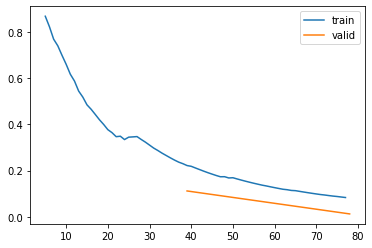

In [22]:
# validation에서 작동이 안 된다면 kernel을 shutdown한 다음 restart를 하자
learn.fit_one_cycle(2,
                   1e-4,
                   cbs=[SaveModelCallback()])
learn.recorder.plot_loss()

# train loss가 0.09 쯤일 때가 가장 좋았다.

# Inference

In [24]:
!pip install opencv-python
clear_output()

In [25]:
# 간단하게 한 장만 확인하는 방법
#learn.predict(file_path+file_name)

In [26]:
# 여기 폴더 명을 달리해서 한다면 언제든지 사용할 수 있다
img_data = ImageFolder(root="/workspace/dataset/sick/test",
                      transform = transforms)


df = {
    "path" : [x[0][10:] for x in img_data.imgs],
    "label" : img_data.targets,
}
test = pd.DataFrame(df)


dtest = ImageDataLoaders.from_df(test, #pass in train DataFrame
                           fn_col='path', 
                           label_col='label',
                           blocks=(ImageBlock, MultiCategoryBlock), #The type of target
                           num_workers=NUM_WORKERS, 
                           item_tfms=Resize(IMG_SIZE))


test_dl = dtest.test_dl(test)
preds, _ = learn.tta(dl=test_dl, 
                     n=4, 
                     beta=0.25)

In [27]:
preds

tensor([[0.9660, 0.0168, 0.0070, 0.0103],
        [0.8534, 0.0834, 0.0410, 0.0222],
        [0.9682, 0.0127, 0.0038, 0.0153],
        [0.9684, 0.0132, 0.0021, 0.0164],
        [0.8970, 0.0732, 0.0086, 0.0211],
        [0.6991, 0.2199, 0.0241, 0.0570],
        [0.0054, 0.9298, 0.0605, 0.0043],
        [0.0036, 0.9754, 0.0178, 0.0032],
        [0.0180, 0.9366, 0.0067, 0.0387],
        [0.0205, 0.1071, 0.8518, 0.0206],
        [0.0426, 0.4152, 0.5038, 0.0384],
        [0.0275, 0.2009, 0.7486, 0.0230],
        [0.0191, 0.1023, 0.8652, 0.0134],
        [0.0148, 0.0433, 0.0083, 0.9336],
        [0.0162, 0.0223, 0.0108, 0.9508],
        [0.0203, 0.0293, 0.0129, 0.9375],
        [0.0060, 0.0384, 0.0218, 0.9339],
        [0.0085, 0.0160, 0.0074, 0.9681]])

In [28]:
result = [ list(p).index(max(p)) for p in preds]
failed = [i for i in range(len(result)) if result[i] != df['label'][i]]

print(df['label'])
print(result)

# 실패한 이미지들
failed

[0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3]
[0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3]


[]

In [29]:
import cv2
import matplotlib.pyplot as plt


print(img_data.class_to_idx)

fig = plt.figure(figsize=(10,10))
rows = len(failed)
cols = 2

nth = 1
for fail in failed:
    img = cv2.imread('/workspace'+df['path'][fail])
    ax = fig.add_subplot(rows, cols, nth)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title( str(df['label'][fail]) + '->' + str(result[fail]))
    ax.axis("off")
    nth += 1
plt.show()

# 실패한 이미지들에 대해서 이미지 보여주기 - 제목 : 정답 -> 오답

{'녹병': 0, '잿빛곰팡이병': 1, '정상': 2, '흰가루병': 3}


<Figure size 720x720 with 0 Axes>

# Model Save and Load

In [30]:
learn.save('withoutYellow')

Path('models/withoutYellow.pth')

In [43]:
n = os.path.getsize('./models/withoutYellow.pth')
"%.2f GB" % (n / (1024.0 * 1024.0 * 1000.0))

'0.99 GB'

In [31]:
del learn

In [34]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '/workspace/swin_base_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_base_patch4_window7_224_22kto1k.pth'

In [65]:
import pandas
import timm
import fastai
from timm import create_model

NUM_WORKERS = 8

# 여기 폴더 명을 달리해서 한다면 언제든지 사용할 수 있다
img_data = ImageFolder(root="/workspace/dataset/sick/test",
                      transform = transforms)
n = len(img_data.classes)

dftest = {
    "path" : [x[0][10:] for x in img_data.imgs],
    "label" : img_data.targets,
}
test = pd.DataFrame(dftest)


dtest = ImageDataLoaders.from_df(test, #pass in train DataFrame
                           fn_col='path', 
                           label_col='label',
                           blocks=(ImageBlock, MultiCategoryBlock), #The type of target
                           num_workers=NUM_WORKERS, 
                           item_tfms=Resize(224))


test_dl = dtest.test_dl(test)

model = create_model('swin_base_patch4_window7_224',  # large는 overfitting, small은 loss는 낮지만 accuracy가 낮음
                     pretrained=True,
                     num_classes=n)

learn = Learner(test_dl,
    model,            
    opt_func = QHAdam,
    loss_func= FocalLossFlat(),
    model_dir = "./models/" 
    ).to_fp16()

learn.load( "withoutYellow")

predTest, _ = learn.tta(dl=test_dl, 
                     n=4, 
                     beta=0.25)

In [66]:
result = [ list(p).index(max(p)) for p in predTest]
failed = [i for i in range(len(result)) if result[i] != dftest['label'][i]]

print(dftest['label'])
print(result)

# 실패한 이미지들
failed

[0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3]
[0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3]


[]